In [1]:
# pull hrrr model data in zarr format from AWS S3
# example source: https://mesowest.utah.edu/html/hrrr/
# AWS S3 bucket: https://hrrrzarr.s3.amazonaws.com/index.html#sfc/
import xarray
import rasterio as rio
import s3fs
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import datetime

In [2]:
s3 = s3fs.S3FileSystem(anon=True)
def lookup(path): 
        return s3fs.S3Map(path, s3=s3) 

In [3]:
# get 1 days worth of data starting today - 4 hours and lookback 6 hours. Convert from system clock to UTC.
endDate = datetime.datetime.now().astimezone(datetime.timezone.utc)
endDate = endDate - datetime.timedelta(hours=4)
lookbackHours = 6
startDate = endDate - datetime.timedelta(hours=lookbackHours)

# get the data "hrrrzarr/sfc/{%Y%m%d}/{%Y%m%d}_{hh}z_fcst.zarr/surface/TMP"
paths = []
for date in range(lookbackHours):
    date = startDate + datetime.timedelta(hours=date)
    path = f"hrrrzarr/sfc/{date:%Y%m%d}/{date:%Y%m%d}_{date:%H}z_anl.zarr/surface/TMP"
    paths.append(path)
paths

['hrrrzarr/sfc/20240718/20240718_09z_anl.zarr/surface/TMP',
 'hrrrzarr/sfc/20240718/20240718_10z_anl.zarr/surface/TMP',
 'hrrrzarr/sfc/20240718/20240718_11z_anl.zarr/surface/TMP',
 'hrrrzarr/sfc/20240718/20240718_12z_anl.zarr/surface/TMP',
 'hrrrzarr/sfc/20240718/20240718_13z_anl.zarr/surface/TMP',
 'hrrrzarr/sfc/20240718/20240718_14z_anl.zarr/surface/TMP']

In [4]:
# load the first dataset
ds = xarray.open_mfdataset([lookup(paths[0]), lookup(f"{paths[0]}/surface")], engine="zarr")
# make time a coordinate
ds = ds.expand_dims(time=[ds.time.data])
# merge the rest of the datasets
for path in paths[1:]:
    ds2 = xarray.open_mfdataset([lookup(path), lookup(f"{path}/surface")], engine="zarr")
    ds2 = ds2.expand_dims(time=[ds2.time.data])
    ds = xarray.concat([ds, ds2], dim="time")


In [5]:
projection = ccrs.LambertConformal( central_longitude = -97.5, 
                                   central_latitude = 38.5, 
                                   standard_parallels = (38.5,38.5), 
                                   cutoff = 0)
# Write the CRS to the dataset
ds = ds.rio.write_crs(projection, inplace=True)

# rename the x and y dimensions to lon and lat
ds = ds.rename({'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})
ds

<xarray.Dataset> Size: 23MB
Dimensions:                  (time: 6, y: 1059, x: 1799)
Coordinates:
  * time                     (time) datetime64[ns] 48B 2024-07-18T09:00:00 .....
  * x                        (x) float64 14kB -2.698e+06 ... 2.696e+06
  * y                        (y) float64 8kB -1.587e+06 -1.584e+06 ... 1.587e+06
    spatial_ref              int64 8B 0
Data variables:
    TMP                      (time, y, x) float16 23MB dask.array<chunksize=(1, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] 48B 00:00:00 ... 00:00:00
    forecast_reference_time  (time) datetime64[ns] 48B 2024-07-18T09:00:00 .....
    height                   (time) float64 48B 1e+03 1e+03 ... 1e+03 1e+03
    pressure                 (time) float64 48B 2.5e+04 2.5e+04 ... 2.5e+04

In [6]:
# plot ds as quadmesh with colorbar
# plt.figure(figsize=(12, 6))
# ax = plt.axes(projection=projection)
# ds.TMP.isel(time = 0).plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'Temperature (K)'})
# # ds3.TMP.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Temperature (K)'})
# ax.coastlines()
# ax.add_feature(cfeature.STATES.with_scale('50m'))
# plt.title(f'HRRR Temperature (K) at {pd.to_datetime(ds3.time.data[0]).strftime('%Y-%m-%d %H:%M')} UTC')

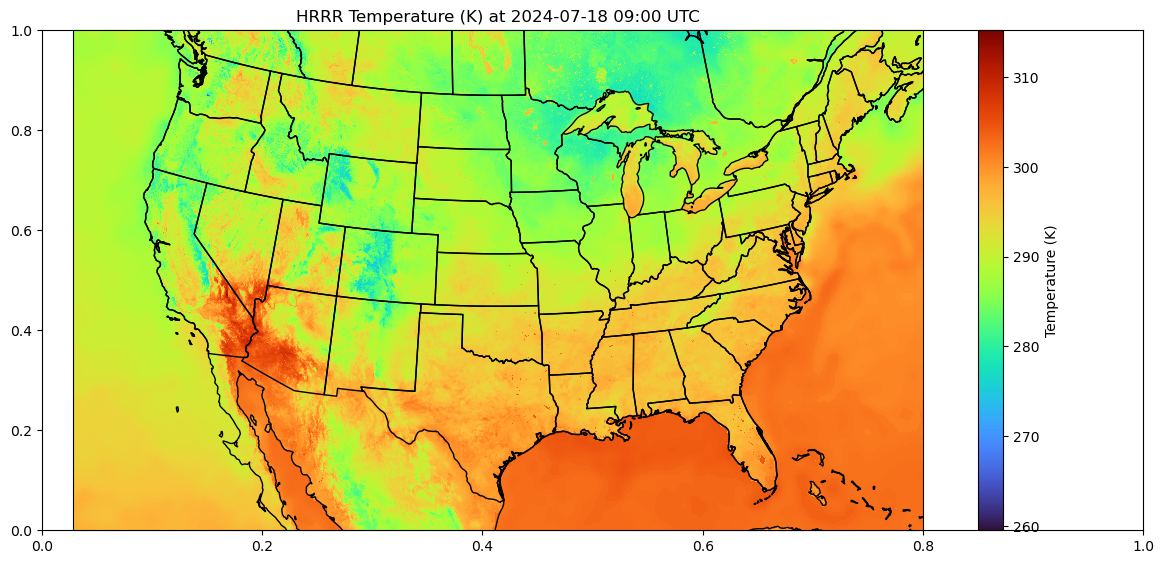

In [7]:
def animate(i): 
    ds.TMP.isel(time = i).plot(ax=ax, add_colorbar=False, cmap='turbo')
    plt.title(f'HRRR Temperature (K) at {pd.to_datetime(ds.time.data[i]).strftime('%Y-%m-%d %H:%M')} UTC')
    plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)

# Setup the figure
fig, ax = plt.subplots(figsize=(12, 6))
ax = plt.axes(projection=projection)
ax.coastlines()
ax.add_feature(cfeature.STATES.with_scale('50m'))	

# add a colorbar
mld = ds.TMP.isel(time=0).plot(ax=ax, add_colorbar= False, cmap='turbo')
cbar = fig.colorbar(mld)

# add label to colorbar
cbar.set_label('Temperature (K)')

# add padding
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)

# create an animation
anim = animation.FuncAnimation(fig, animate, interval=1000, frames=range(0, len(ds["time"]))) 
anim.save('hrrr.mp4', writer='ffmpeg')
HTML(anim.to_jshtml())
